In [41]:
import math

import re

import time

from google.colab import drive

In [42]:

try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers

import tensorflow_datasets as tfds

In [43]:
import pandas as pd

import numpy as np

import h5py

from gensim.models import Word2Vec

import gensim.models

from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Embedding

from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation

from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import SimpleRNN

from tensorflow.keras.layers import GRU

from tensorflow.keras.preprocessing.sequence import pad_sequences 

import re

from nltk.tokenize import word_tokenize

import nltk

nltk.download('punkt')

from nltk.corpus import stopwords 

nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
data_clickbait = pd . read_csv ('/content/drive/My Drive/clickbait_data' , sep = ' \ n ' , header = None )

data_noclickbait = pd . read_csv ('/content/drive/My Drive/non_clickbait_data' , sep = ' \ n ' , header = None )

data_clickbait = data_clickbait.sample(frac = 7.5/16)

data_noclickbait = data_noclickbait.sample(frac = 7.5/16)

data_clickbait['class'] = [1 for i in range(7500)]

data_noclickbait['class'] = [0 for i in range(7500)] 

data_Final = pd . concat (( data_clickbait , data_noclickbait ), ignore_index = True ) 

df = data_Final . rename ( columns = { 0 : "text" })

df = df . sample ( frac = 1 ). reset_index ( drop = True )

print (df.shape)

print (df.head(5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


(15000, 2)
                                                text  class
0   Iraqi Sunnis Turn to Politics and Renew Strength      0
1  9 Alumni of Saudi Program for Ex-Jihadists Are...      0
2        Brits Respond To Questions From Australians      1
3       Do You Know How Much Your Old Toys Are Worth      1
4  Were You More Harry Styles Or Justin Bieber In...      1


In [46]:
df

,text,class
0,Iraqi Sunnis Turn to Politics and Renew Strength,0
1,9 Alumni of Saudi Program for Ex-Jihadists Are...,0
2,Brits Respond To Questions From Australians,1
3,Do You Know How Much Your Old Toys Are Worth,1
4,Were You More Harry Styles Or Justin Bieber In...,1
...,...,...
14995,Organization of American States votes to lift ...,0
14996,This Woman Makes Tiny Fake Food And It's Incre...,1
14997,22 Books Every Twentysomething Guy Needs To Read,1
14998,"Chinese quake death toll nears 32,500, as a ma...",0


In [47]:
stop_words  =  set ( stopwords . words ( 'english' ))

In [48]:
from sklearn.model_selection import train_test_split

L = []
for  i , token  in  enumerate ( df [ 'text' ]):
    words = [ w  for  w  in  token . split () if  not  w  in  stop_words ]
    L . append ( len ( words ))
    
sequence_size = max ( L )


X = df['text']

y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [49]:
y_train = np.array(y_train)

y_test = np.array(y_test)

y_val = np.array(y_val)

In [50]:
WORD2VEC_VECTORS_BIN  = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin'

w2v  =  gensim . models . KeyedVectors . load_word2vec_format ( WORD2VEC_VECTORS_BIN , binary = True )

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [51]:
train_data=np.zeros((len(X_train), sequence_size, 300))

val_data=np.zeros((len(X_val), sequence_size, 300))

test_data = np.zeros((len(X_test), sequence_size, 300))

for i,sentence in enumerate(X_train) :

  sentence = sentence.replace('-', ' ')

  words = nltk.word_tokenize(sentence)

  j = 0 

  for  w  in  words :

    try :
        
      train_data [ i , j ] = w2v [ w ]

      j += 1

    except :
        
      pass

for i,sentence in enumerate(X_val) :

  sentence = sentence.replace('-',' ')

  words = nltk.word_tokenize(sentence)

  j = 0
  
  for  w  in  words :

    try :
        
      val_data [ i , j ] = w2v [ w ]

      j += 1

    except :
        
      pass
        

for i,sentence in enumerate(X_test) :

  sentence = sentence.replace('-',' ')

  words = nltk.word_tokenize(sentence)

  j = 0
  
  for  w  in  words :

    try :
        
      test_data [ i , j ] = w2v [ w ]

      j += 1

    except :
        
      pass
  
print (test_data.shape)
print (train_data.shape)
print (val_data.shape)

(3000, 21, 300)
(9000, 21, 300)
(3000, 21, 300)


In [52]:
class PositionalEncoding(layers.Layer):
  
    def __init__(self) :

        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model) :

        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))

        return pos * angles

    def call(self, inputs) :

        seq_length = inputs.shape.as_list()[-2]

        d_model = inputs.shape.as_list()[-1]

        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)

        angles[:, 0::2] = np.sin(angles[:, 0::2])

        angles[:, 1::2] = np.cos(angles[:, 1::2])
        
        pos_encoding = angles[np.newaxis, ...]

        return inputs + tf.cast(pos_encoding, tf.float32)

In [53]:
def scaled_dot_product_attention(queries, keys, values, mask) :
  
    product = tf.matmul(queries, keys, transpose_b  = True)
    
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)

    scaled_product = product / tf.math.sqrt(keys_dim)
    
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis = -1), values)
    
    return attention

In [54]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, nb_proj) :

        super(MultiHeadAttention, self).__init__()

        self.nb_proj = nb_proj
        
    def build(self, input_shape) :

        self.d_model = input_shape[-1]

        assert self.d_model % self.nb_proj == 0
        
        self.d_proj = self.d_model // self.nb_proj
        
        self.query_lin = layers.Dense(units=self.d_model)

        self.key_lin = layers.Dense(units=self.d_model)

        self.value_lin = layers.Dense(units=self.d_model)
        
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)

        shape = (batch_size,-1, self.nb_proj,self.d_proj)

        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)

        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask) :

        batch_size = tf.shape(queries)[0]
        
        queries = self.query_lin(queries)

        keys = self.key_lin(keys)

        values = self.value_lin(values)
        
        queries = self.split_proj(queries, batch_size)

        keys = self.split_proj(keys, batch_size)

        values = self.split_proj(values, batch_size)
        
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(attention,shape=(batch_size, -1, self.d_model))
        
        outputs = self.final_lin(concat_attention)
        
        return outputs

In [55]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, nb_proj, dropout_rate) :

        super(EncoderLayer, self).__init__()

        self.FFN_units = FFN_units

        self.nb_proj = nb_proj

        self.dropout_rate = dropout_rate
    
    def build(self, input_shape) :

        self.d_model = input_shape[-1]
        
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)

        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)

        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")

        self.dense_2 = layers.Dense(units=self.d_model)

        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)

        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training) :

        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        
        attention = self.dropout_1(attention, training=training)

        attention = self.norm_1(attention + inputs)
        
        outputs = self.dense_1(attention)

        outputs = self.dense_2(outputs)

        outputs = self.dropout_2(outputs, training=training)
        
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [56]:
class Encoder(layers.Layer) :
    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 d_model,
                 name="encoder") :

        super(Encoder, self).__init__(name=name)

        self.nb_layers = nb_layers

        self.d_model = d_model
        
        self.pos_encoding = PositionalEncoding()

        self.dropout = layers.Dropout(rate=dropout_rate)

        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, mask, training) :


        inputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        outputs = self.pos_encoding(inputs)

        outputs = self.dropout(outputs, training)
        
        for i in range(self.nb_layers) :
          
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

In [57]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        
        self.encoder = Encoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               d_model)
        # self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq):
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, training = True):
        enc_mask = self.create_padding_mask(enc_inputs)
        
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        
        return enc_outputs

In [58]:
D_MODEL = 300

NB_LAYERS = 2

FFN_UNITS = 512

NB_PROJ = 4

DROPOUT_RATE = 0.1

transformer = Transformer(d_model = D_MODEL,
                          nb_layers = NB_LAYERS,
                          FFN_units = FFN_UNITS,
                          nb_proj = NB_PROJ,
                          dropout_rate = DROPOUT_RATE)


inputs = layers.Input(shape = (sequence_size,D_MODEL))

x = transformer(inputs)

x = layers.Flatten()(x)

x = layers.Dense(512, activation="relu")(x)

x = layers.Dropout(0.1)(x)

x = layers.Dense(256, activation="relu")(x)

x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.summary()

model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 21, 300)]         0         
_________________________________________________________________
transformer (Transformer)    (None, 21, 300)           1340824   
_________________________________________________________________
flatten_1 (Flatten)          (None, 6300)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               3226112   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0   

In [59]:
history = model.fit(train_data , y_train  , batch_size = 64 , epochs = 20 , validation_data = (val_data , y_val), verbose = 1)

Epoch 1/20
141/141 [==============================] - 6s 41ms/step - loss: 0.2683 - accuracy: 0.9294 - val_loss: 0.0819 - val_accuracy: 0.9630
Epoch 2/20
141/141 [==============================] - 5s 35ms/step - loss: 0.0688 - accuracy: 0.9782 - val_loss: 0.1112 - val_accuracy: 0.9677
Epoch 3/20
141/141 [==============================] - 5s 35ms/step - loss: 0.0492 - accuracy: 0.9846 - val_loss: 0.0758 - val_accuracy: 0.9807
Epoch 4/20
141/141 [==============================] - 5s 35ms/step - loss: 0.0437 - accuracy: 0.9862 - val_loss: 0.0487 - val_accuracy: 0.9810
Epoch 5/20
141/141 [==============================] - 5s 35ms/step - loss: 0.0336 - accuracy: 0.9884 - val_loss: 0.0572 - val_accuracy: 0.9843
Epoch 6/20
141/141 [==============================] - 5s 35ms/step - loss: 0.0464 - accuracy: 0.9852 - val_loss: 0.0566 - val_accuracy: 0.9820
Epoch 7/20
141/141 [==============================] - 5s 36ms/step - loss: 0.0359 - accuracy: 0.9882 - val_loss: 0.0892 - val_accuracy: 0.9810

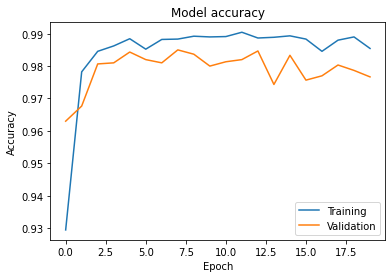

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

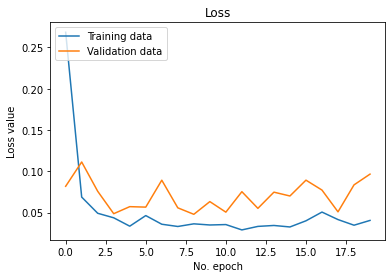

In [61]:
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [62]:
y_pred = model.predict(test_data)

In [63]:
y_pred

array([[9.9979550e-01],
       [8.9673867e-06],
       [6.0092570e-06],
       ...,
       [7.7912255e-06],
       [5.2564328e-06],
       [9.9983442e-01]], dtype=float32)

In [64]:
y_pred.shape

(3000, 1)

In [65]:
for i in range(y_pred.shape[0]) :

  if y_pred[i][0] >= 0.5 :

    y_pred[i][0] = 1

  else :

    y_pred[i][0] = 0

In [66]:
y_pred = y_pred.astype('int64')

In [67]:
y_pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [68]:
y_test = y_test.reshape(-1,1)

In [69]:
metrics  =  classification_report (y_test , y_pred)

print ('Classification Report ')

print("\n")

print (metrics)

cm  =  confusion_matrix (y_test,y_pred)

print ('Confusion Matrix')

print("\n")

print (cm)

Classification Report 


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1506
           1       0.97      0.99      0.98      1494

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000

Confusion Matrix


[[1456   50]
 [  14 1480]]


In [74]:
X = np.zeros((1,sequence_size,300))

sentence = "78 wonderful things about paper"

sentence = sentence.replace('-',' ')

words = nltk.word_tokenize(sentence)

j = 0

for  w  in  words :

    try :
        
      X[0,j] = w2v[w]

      j += 1

    except :
        
      pass

In [75]:
def predict(a) :

  for i in range(a.shape[0]) :

    if a[i][0] >= 0.5 :

      a[i][0] = 1

    else :

      a[i][0] = 0

  return a

In [76]:
predict(model.predict(X))

array([[1.]], dtype=float32)